## A simple model for demand and supply of publicly-provided services in a city

In [1]:
from enum import Enum
import os.path

import numpy as np
import pandas as pd
import geopandas as gpd
import geopy, geopy.distance
import shapely
from sklearn import gaussian_process

from matplotlib import pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize']= (20,14)

In [2]:
## TODO: find way to put this into some global settings
import os
import sys
nb_dir = os.path.dirname(os.getcwd())
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import commonCfg

In [3]:
from src.models.cityItems import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model

In [4]:
gaussKern = gaussian_process.kernels.RBF
get_random_pos = lambda n: list(map(geopy.Point, list(zip(np.round(np.random.uniform(45.40, 45.50, n), 5), 
                                np.round(np.random.uniform(9.1, 9.3, n), 5)))))
make_shapely_point = lambda geoPoint: shapely.geometry.Point((geoPoint.longitude, geoPoint.latitude))

In [5]:
## ServiceUnit class
class ServiceUnit:
    def __init__(self, service, name='', position=geopy.Point(45.4641, 9.1919),
                 ageDiffusionIn={}, scaleIn=1, attributesIn={}):
        assert isinstance(position, geopy.Point), 'Position must be a geopy Point' 
        assert isinstance(service, ServiceType), 'Service must belong to the Eum'
        assert isinstance(name, str), 'Name must be a string'
        
        assert (np.isscalar(scaleIn)) & (scaleIn>0) , 'Scale must be a positive scalar'
        assert isinstance(attributesIn, dict), 'Attributes can be provided in a dict'
        
        self.name = name
        self.service = service
        
        # A ServiceType can have many sites, so each unit has its own. 
        # Moreover, a site is not uniquely assigned to a service
        self.site = position
        
        self.scale = scaleIn # store scale info
        self.attributes = attributesIn# dictionary
        
        # how the service availablity area varies for different age groups
        if ageDiffusionIn==None:
            self.ageDiffusion = {g: (
                1 + .005*np.round(np.random.normal(),2))*self.scale for g in AgeGroup.all()} 
        else:
            assert set(ageDiffusionIn.keys()) <= set(AgeGroup.all()), 'Diffusion keys should be AgeGroups'
            #assert all
            self.ageDiffusion = ageDiffusionIn
            
        # define kernel taking scale into account
        self.kernel = {g: gaussKern(length_scale=l*self.scale) for g, l in self.ageDiffusion.items()}
        
        
    def evaluate(self, targetPositions, ageGroup):
        assert all([isinstance(t, geopy.Point) for t in targetPositions]),'Geopy Points expected'
        
        # get distances
        distances = np.zeros(shape=(len(targetPositions),1))
        distances[:,0] = [geopy.distance.great_circle(x, self.site).km for x in targetPositions]
        
        # evaluate kernel to get level service score. If age group is not relevant to the service, return 0 as default
        if self.kernel.__contains__(ageGroup):
            score = self.kernel[ageGroup](distances, np.array([[0],]))
            # check conversion from tuple to nparray
            #targetPositions= np.array(targetPositions)
            #score2 = self.kernel[ageGroup](targetPositions, reshapedPos)
            #assert all(score-score2==0)
        else:
            score = np.zeros_like(targetPositions)
        return np.squeeze(score)
    
    @property
    def users(self): return list(self.propagation.keys())

In [6]:
### Supply modelling
def evaluate_services_at(positions, unitsList, outputServices= [t for t in ServiceType]):
    assert all([isinstance(t, geopy.Point) for t in positions]),'Geopy Points expected'
    # set all age groups as output default
    outputAgeGroups = AgeGroup.all()
    # initialise output
    outScores = {service: pd.DataFrame(np.zeros([len(positions), len(AgeGroup.all())]), 
                                 index=[tuple(t) for t in positions], columns=AgeGroup.all()) 
                 for service in outputServices}
    # loop over different services
    for thisServType in outputServices:
        serviceUnits = [u for u in unitsList if u.service == thisServType]
        if not serviceUnits:
            continue
        else:
            for thisAgeGroup in outputAgeGroups:
                unitValues = np.stack(list(map(
                    lambda x: x.evaluate(positions, thisAgeGroup), serviceUnits)), axis=-1)
                # aggregate unit contributions according to the service type norm
                outScores[thisServType][thisAgeGroup] = thisServType.aggregate_units(unitValues)
            
    return outScores
        

In [7]:
quicktest = [ServiceUnit(ServiceType.PoliceStation, 'Duomo', ageDiffusionIn=None), 
        ServiceUnit(ServiceType.PoliceStation, 'Ripamonti', 
                    position=geopy.Point(45.43, 9.201), ageDiffusionIn=None)]

#evaluate_services_at(get_random_pos(4), test)
del quicktest

In [8]:
class UnitFactory:
    def __init__(self, path):
        assert os.path.isfile(path), 'File "%s" not found' % path
        self.filepath = path
        self.rawData = []
        
    def load(self):
        self.rawData = pd.read_csv(self.filepath, sep=';', decimal=',')
        self.nUnits = self.rawData.shape[0]
        defaultLocationColumns = ['Lat', 'Long']
        if set(defaultLocationColumns).issubset(set(self.rawData.columns)):
            print('Location data found')
            # store geolocations as geopy Point
            locations = [geopy.Point(self.rawData.loc[i, defaultLocationColumns]) for i in range(self.nUnits)]
            propertData = self.rawData.drop(defaultLocationColumns, axis=1)
        else:
            propertData = self.rawData
            locations = []
            
        return propertData, locations

    @staticmethod
    def createLoader(serviceType, path):
        if serviceType == ServiceType.School:
            return SchoolFactory(path)

In [9]:
class SchoolFactory(UnitFactory):
    
    def __init__(self, path):
        super().__init__(path)
        
    def load(self, meanRadius):
        
        assert meanRadius, 'Please provide a reference radius for the mean school size'
        (propertData, locations) = super().load()
        
        nameCol = 'DENOMINAZIONESCUOLA'
        typeCol = 'ORDINESCUOLA'
        scaleCol = 'ALUNNI'
        
        typeAgeDict = {'SCUOLA PRIMARIA': {AgeGroup.ChildPrimary:1},
                      'SCUOLA SECONDARIA I GRADO': {AgeGroup.ChildMid:1},
                      'SCUOLA SECONDARIA II GRADO': {AgeGroup.ChildHigh:1},}
        
        schoolTypes = propertData[typeCol].unique()
        assert set(schoolTypes) <= set(typeAgeDict.keys()), 'Unrecognized types in input'
        
        # set the scale to be proportional to the square root of number of children
        scaleData = propertData[scaleCol]**.5
        scaleData = scaleData/scaleData.mean() * meanRadius #mean value is mapped to input parameter
        propertData[scaleCol] = scaleData 
        unitList = []
                
        for scType in schoolTypes:
            bThisGroup = propertData[typeCol]==scType
            typeData = propertData[bThisGroup]
            typeLocations = [l for i,l in enumerate(locations) if bThisGroup[i]]

            for iUnit in range(typeData.shape[0]):
                rowData = typeData.iloc[iUnit,:]
                attrDict = {'level':scType}
                thisUnit = ServiceUnit(ServiceType.School, 
                        name=rowData[nameCol], 
                        position=typeLocations[iUnit], 
                        ageDiffusionIn=typeAgeDict[scType], 
                        scaleIn=rowData[scaleCol],
                        attributesIn=attrDict)
                unitList.append(thisUnit)
        
        return unitList

In [13]:
## Load scuole
scuoleFile =  '../data/processed/Milano_datiScuole.csv'
schoolLoader = UnitFactory.createLoader(ServiceType.School, scuoleFile)

# Initialise with a default lengthscale of 0.5 km
schoolUnits = schoolLoader.load(meanRadius=0.5)

Location data found


In [14]:
## Aggregation
class UnitAggregator:
    '''
    A class to evaluate services on a grid and get average values for given land subdivisions
    '''
    
    def __init__(self, unitList, cityGeoFilesDict, IDQuartiereField, gridStep=0.1): #gridStep in km
        assert isinstance(unitList, list), 'List expected'
        assert all([isinstance(t, ServiceUnit) for t in unitList]), 'ServiceUnits expected in list'
        self.units = unitList
        self.quartiereKey = 'quartieri' #hardcoded
        self.IDquartiereCol = IDQuartiereField
        
        # initialise values on grid
        self.serviceValues = {}
        
        # load division geofiles with geopandas
        self.subdivisions = {}
        for name, fileName in cityGeoFilesDict.items():
            self.subdivisions[name] = gpd.read_file(fileName)
        
        # compute city boundary
        self.cityBoundary = shapely.ops.cascaded_union(self.subdivisions[self.quartiereKey]['geometry'])
        
        # precompute coordinate rangesquartiereKey
        self.longRange = (self.cityBoundary.bounds[0], self.cityBoundary.bounds[2])
        self.latRange = (self.cityBoundary.bounds[1], self.cityBoundary.bounds[3])
        self.longNGrid = int(self.longitudeRangeKm // gridStep)+1
        self.latNGrid = int(self.latitudeRangeKm // gridStep)+1
        
        # precompute plotting grid
        (self.xPlot, self.yPlot) = np.meshgrid(np.linspace(*self.longRange, self.longNGrid),
                                               np.linspace(*self.latRange, self.latNGrid),
                                        indexing='ij')
        
        # construct point objects with same shape
        self.plotPoints = np.empty_like(self.xPlot, dtype=object)
        self.bInPerimeter = np.empty_like(self.xPlot, dtype=bool)
        self.IDquartiere = np.empty_like(self.xPlot, dtype=object)
        
        for (i,j),_ in np.ndenumerate(self.plotPoints):
            self.plotPoints[i,j] = geopy.Point(self.yPlot[i,j], self.xPlot[i,j]) # (lat, long) format
            shplyPoint = make_shapely_point(self.plotPoints[i,j])
            # mark points outside boundaries
            self.bInPerimeter[i,j] = self.cityBoundary.contains(shplyPoint)
            if self.bInPerimeter[i,j]:
                bFound = False
                for iRow in range(self.subdivisions[self.quartiereKey].shape[0]):
                    thisQuartierePolygon = self.subdivisions[self.quartiereKey]['geometry'][iRow]
                    if thisQuartierePolygon.contains(shplyPoint):
                        # assign found ID
                        self.IDquartiere[i,j] = self.subdivisions[
                            self.quartiereKey][self.IDquartiereCol][iRow]
                        bFound = True
                        break # skip remanining zones
                assert bFound, 'Point within city boundary was not assigned to any zone'
        
    
    @property
    def longitude(self):
        return [unit.site.longitude for unit in self.units]
    @property
    def longitudeRangeKm(self):
        return geopy.distance.great_circle(
            (self.latRange[0], self.longRange[0]), (self.latRange[0], self.longRange[1])).km
    @property
    def latitudeRangeKm(self):
        return geopy.distance.great_circle(
            (self.latRange[0], self.longRange[0]), (self.latRange[1], self.longRange[0])).km
    @property
    def latitude(self):
        return [unit.site.latitude for unit in self.units]
    @property
    def scale(self):
        scales = [unit.scale for unit in self.units]
        return scales
    
    def compute_service_levels(self, servType):
        '''
        Evaluates on a grid the aggregate service level for the loaded ServiceUnits of a selected type.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        
        # extend internal cache with computed values
        self.serviceValues[servType] = evaluate_services_at(
            self.plotPoints.reshape(-1), self.units, [servType])[servType]
        return None
    
    @property
    def aggregate_values(self):
        
        assert self.serviceValues, 'Empty values on grid found, compute first please!'
        
        quartieri = self.subdivisions[self.quartiereKey][self.IDquartiereCol].values
        
        # initialize output
        averagedValues = {service: pd.DataFrame(np.zeros([len(quartieri), len(AgeGroup.all())]), 
                                 index=quartieri, columns=AgeGroup.all()) 
                 for service in self.serviceValues.keys()}
      
        leftOutZones = []
        for quartiere in quartieri:
            bThisQuartiere = (self.IDquartiere == quartiere)
            # loop over service types
            if not bThisQuartiere.any():
                print('Quartiere %s has no points in grid within it' % quartiere)
                leftOutZones.append(quartiere)
                continue
                
            for servType in self.serviceValues.keys():
                for ageGroup, valuesSeries in self.serviceValues[servType].items(): 
                    quartiereValues = [valuesSeries[tuple(p)] for p in self.plotPoints[bThisQuartiere]]
                    averagedValues[servType].loc[quartiere, ageGroup] = np.mean(quartiereValues)
                    
        return averagedValues, leftOutZones

In [26]:
# Prepare service level aggregation by quartiere
schoolAggr = UnitAggregator(schoolUnits, 
                {'quartieri':'../data/raw/Milano_specific/Milano_quartieri.geojson'},
                IDQuartiereField = commonCfg.IdQuartiereColName,
                gridStep=.5)

In [27]:
## Plot tools
from descartes import PolygonPatch

class unitPlotter:
    '''
    A class that plots various types of output from a UnitAggregator
    '''
    def __init__(self, unitAggregatorIn):
        assert isinstance(unitAggregatorIn, UnitAggregator), 'UnitAggregator class expected'
        self.ua = unitAggregatorIn
        
    def plot_locations(self):
        '''
        Plots the loaded ServiceUnits according to their locations and rescale them by the relative sizes
        '''
        plotScales = self.ua.scale/np.mean(self.ua.scale)
        plt.figure()
        plt.scatter(self.ua.longitude, self.ua.latitude, s=plotScales)
        plt.axis('equal')
        plt.show()
        return None
        
    def plot_grid_and_boundary(self):
        fig = plt.figure()
        ax = fig.gca()
        plt.scatter(self.ua.xPlot[self.ua.bInPerimeter], self.ua.yPlot[self.ua.bInPerimeter], cmap='k', s=1)
        ax.add_patch(PolygonPatch(self.ua.cityBoundary, fc='None',zorder=5))
        plt.axis('equal')
        plt.show()
        return None
        
    def plot_service_levels(self, servType):
        '''
        Plots a contour graph of the results for each ageGroup.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        
        for ageGroup, valuesSeries in self.ua.serviceValues[servType].items():
            valuesArray = np.vectorize(lambda p: valuesSeries[tuple(p)])(self.ua.plotPoints)
            if np.count_nonzero(valuesArray) > 0:
                plt.figure()
                plt.title(ageGroup)
                CS = plt.contourf(self.ua.xPlot, self.ua.yPlot, valuesArray, 40)
                cbar = plt.colorbar(CS)
                cbar.ax.set_ylabel('Service level')
                plt.show()
            
        return None

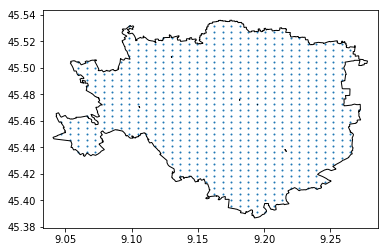

In [28]:
plotterNew= unitPlotter(schoolAggr)
plotterNew.plot_grid_and_boundary()
#plotterNew.plot_service_levels(ServiceType.School)

In [29]:
# Run evalutation
schoolAggr.compute_service_levels(ServiceType.School)

In [41]:
# Save and display aggregate values for zones
out, _ = schoolAggr.aggregate_values
finalSchoolData = out[ServiceType.School].rename_axis(
    schoolAggr.IDquartiereCol)
finalSchoolData.to_csv('../data/output/Milano_schoolSample.csv', encoding='utf-8')
finalSchoolData

,AgeGroup.Newborn,AgeGroup.ChildPrimary,AgeGroup.ChildMid,AgeGroup.ChildHigh,AgeGroup.Young,AgeGroup.Junior,AgeGroup.Senior,AgeGroup.Over50,AgeGroup.Over65,AgeGroup.Over80
IDquartiere,,,,,,,,,,
74,0.0,0.400747,0.442491,0.565595,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,1.025707,0.627133,1.639026,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.528039,0.469244,0.700769,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.950675,0.813625,1.407984,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.981270,0.830653,1.061752,0.0,0.0,0.0,0.0,0.0,0.0
72,0.0,0.328468,0.155362,0.584019,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.724153,0.471709,1.226263,0.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.759227,0.563401,0.953845,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.823692,0.675758,1.240536,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
outtest = pd.read_csv('../data/output/Milano_schoolSample.csv',
                     index_col=commonCfg.IdQuartiereColName)
outtest

,AgeGroup.Newborn,AgeGroup.ChildPrimary,AgeGroup.ChildMid,AgeGroup.ChildHigh,AgeGroup.Young,AgeGroup.Junior,AgeGroup.Senior,AgeGroup.Over50,AgeGroup.Over65,AgeGroup.Over80
IDquartiere,,,,,,,,,,
74,0.0,0.400747,0.442491,0.565595,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,1.025707,0.627133,1.639026,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.528039,0.469244,0.700769,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.950675,0.813625,1.407984,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.981270,0.830653,1.061752,0.0,0.0,0.0,0.0,0.0,0.0
72,0.0,0.328468,0.155362,0.584019,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.724153,0.471709,1.226263,0.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.759227,0.563401,0.953845,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.823692,0.675758,1.240536,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
plotterNew.plot_service_levels(ServiceType.School)

## Demand modelling

In [ ]:
### Demand modelling
class Household:
    def __init__(self, position=None, membersInput=None):
        # make defaults
        if not position: position = get_random_pos(1)
        if not membersInput: membersInput = {a: 1 for a in AgeGroup.all()}
        # expand input to all age group keys
        self.members = {a: membersInput.get(a, 0) for a in AgeGroup.all()}
        self.position = position
        self.export = pd.DataFrame(self.members, index=([self.position])) # precompute for speed

def evaluate_demand(householdList, outputServices= [t for t in ServiceType]):
    """ """
    # initialise output
    outDemand = dict()
    # consolidate positions. If two households share the same position, sum components.
    householdData = pd.concat([h.export for h in householdList])
    householdData['position'] = householdData.index 
    consolidated = householdData.groupby('position').sum()
    
    for thisServType in outputServices:
        outDemand[thisServType] = consolidated*thisServType.demandFactors
        
    return outDemand

In [ ]:
hhList =  [Household() for i in range(40)]
evaluate_demand(hhList)

In [ ]:
## Matching demand and supply
def get_satisfaction_indexes(householdList):
    pass